글꼴 설정

In [4]:
# matplotlib library load
import matplotlib.pyplot as plt

# plot 한글 보이게
from matplotlib import rc
rc('font', family='NanumGothic')
plt.rcParams['axes.unicode_minus'] = False

In [5]:
plt.rcParams['axes.unicode_minus'] = False

# 1. Data preprocessing

## 1.1 Data Preparing and column removing

In [6]:
import pandas as pd

# 데이터 불러와서 변수에 저장
for month in range(9,11):
    for day in range(1,31):

        refined_month = str(month).zfill(2)
        refined_day = str(day).zfill(2)

        file_name = f'data_{refined_month}_{refined_day}'
        file_path = fr'D:\KNU\2-2\산학 Final\Non Time series\2023-{refined_month}-{refined_day}.csv'

        # CSV 파일 읽기 (EUC-KR로 인코딩된 경우)
        data = pd.read_csv(file_path, encoding='euc-kr',index_col=False)
        globals()[file_name] = data.set_index(data.columns[0])

In [7]:
''' Notice : 시계열 데이터로 처리하고 싶으면 이부분 전처리 코드 바꾸면 됩니다. '''

combined_df = pd.DataFrame()

for month in range(9,11):
    for day in range(1,31):

        refined_month = str(month).zfill(2)
        refined_day = str(day).zfill(2)

        file_name = f'data_{refined_month}_{refined_day}'

        combined_df = pd.concat([combined_df, globals()[file_name]], ignore_index=False)

In [8]:
not_zero_df = combined_df[combined_df['열 손실법 효율'] != 0]

In [9]:
columns_to_remove = []

for column in not_zero_df.columns:
    # 모든 값이 동일한지 확인
    if not_zero_df[column].nunique() == 1:
        columns_to_remove.append(column)
        print(f"칼럼 '{column}'의 모든 값은 동일합니다.")

칼럼 '설정 압력'의 모든 값은 동일합니다.
칼럼 '재순환 댐퍼'의 모든 값은 동일합니다.
칼럼 '버너온도'의 모든 값은 동일합니다.
칼럼 '재순환 NOx'의 모든 값은 동일합니다.


In [10]:
# 칼럼 제거
columns_to_remove.append('정상 운전 확률')
columns_to_remove.append('확률 업데이트 시간')
columns_to_remove.append('운전시간')
columns_to_remove.append('입출력법 효율')
columns_to_remove.append('효율(순간)')

In [11]:
droped_df = not_zero_df.drop(columns_to_remove, axis=1)

In [12]:
droped_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 87956 entries, 2023-09-01 08:50:59 to 2023-10-30 21:48:46
Data columns (total 35 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   부하율           87956 non-null  float64
 1   보일러 압력        87956 non-null  float64
 2   송풍기 인버터 출력    87956 non-null  float64
 3   송풍기 입력        87956 non-null  float64
 4   급수 펌프         87956 non-null  float64
 5   급수펌프 입력       87956 non-null  float64
 6   가스 댐퍼         87956 non-null  float64
 7   가스 댐퍼 입력      87956 non-null  float64
 8   Air 댐퍼        87956 non-null  float64
 9   Air 댐퍼 입력     87956 non-null  float64
 10  재순환 외기 댐퍼     87956 non-null  float64
 11  재순환 댐퍼 입력     87956 non-null  float64
 12  재순환 외기 댐퍼 입력  87956 non-null  float64
 13  급수 수위         87956 non-null  float64
 14  보일러 온도        87956 non-null  float64
 15  배기가스온도1       87956 non-null  float64
 16  배기가스온도2       87956 non-null  float64
 17  배기가스온도3       87956 non-null  float64
 18 

In [13]:
droped_df.to_csv('doroped_df.csv')

## 1.2 주음제거

In [14]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# 데이터 전처리: 표준화
scaler = StandardScaler()
scaled_data = scaler.fit_transform(droped_df)

# PCA 수행
pca = PCA(n_components=scaled_data.shape[1])
pca.fit(scaled_data)

# PC1,2 제거: 첫 번째, 두번쨰 주성분을 제외한 나머지 주성분으로 데이터 재구성
remove_pc_num = 2
pc_removed_data = pca.transform(scaled_data)[:, remove_pc_num:]  # 첫 번째, 두번쨰 주성분 제외
pc_removed_reconstructed = pca.inverse_transform(np.hstack([np.zeros((pc_removed_data.shape[0], remove_pc_num)), pc_removed_data]))
pc_removed_df = pd.DataFrame(scaler.inverse_transform(pc_removed_reconstructed), index=droped_df.index, columns=droped_df.columns)

# 2. Model Fitting

## 2.1 XGBRegression

### 2.1.1 XGBRegression modeling

In [15]:
from sklearn.model_selection import train_test_split
import xgboost
from sklearn.ensemble import RandomForestRegressor
import shap

X = pc_removed_df.drop('열 손실법 효율', axis=1)
y = pc_removed_df['열 손실법 효율']

# 훈련 데이터와 검정 데이터 그리고 테스트 데이터로 나누기

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

### 2.1.1 Bayesian Optimization implementation

In [16]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.metrics import mean_squared_error
from hyperopt.pyll.base import scope

#Define the space over which hyperopt will search for optimal hyperparameters.
space = {'max_depth': scope.int(hp.quniform("max_depth", 1, 5, 1)),
        'gamma': hp.uniform ('gamma', 0,1),
        'reg_alpha' : hp.uniform('reg_alpha', 0,50),
        'reg_lambda' : hp.uniform('reg_lambda', 10,100),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0,1),
        'min_child_weight' : hp.uniform('min_child_weight', 0, 5),
        'n_estimators': 10000,
        'learning_rate': hp.uniform('learning_rate', 0, .15),
        'tree_method':'gpu_hist', 
        'gpu_id': 0,
        'random_state': 5,
        'max_bin' : scope.int(hp.quniform('max_bin', 200, 550, 1))}

In [17]:
#Define the hyperopt objective.
def hyperparameter_tuning(space):
    model = xgboost.XGBRegressor(**space)
    
    #Define evaluation datasets.
    evaluation = [(X_train, y_train), (X_valid, y_valid)]
    
    #Fit the model. Define evaluation sets, early_stopping_rounds, and eval_metric.
    model.fit(X_train, y_train,
            eval_set=evaluation, eval_metric="rmse",
            early_stopping_rounds=100,verbose=False)

    #Obtain prediction and rmse score.
    pred = model.predict(X_valid)
    rmse = mean_squared_error(y_valid, pred, squared=False)
    print ("SCORE:", rmse)
    
    #Specify what the loss is for each model.
    return {'loss':rmse, 'status': STATUS_OK, 'model': model}

In [ ]:
#Run 20 trials.
trials = Trials()
best = fmin(fn=hyperparameter_tuning,
            space=space,
            algo=tpe.suggest,
            max_evals=30,
            trials=trials)

print(best)

  0%|          | 0/30 [00:00<?, ?trial/s, best loss=?]

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

[00:52:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:45: `gpu_id` is deprecated since2.0.0, use `device` instead. E.g. device=cpu/cuda/cuda:0

[00:52:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\context.cc:44: No visible GPU is found, setting device to CPU.

[00:52:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training

  0%|          | 0/30 [00:00<?, ?trial/s, best loss=?]


XGBoostError: [00:52:23] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:781: Exception in gpu_hist: [00:52:23] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\tree\updater_gpu_hist.cu:787: Check failed: ctx_->gpu_id >= 0 (-1 vs. 0) : Must have at least one device


위 코드는 GPU 사용떄문에 Colab환경에서 실행되었습니다.
T4 GPU를 사용하였습니다.

### 2.1.2 XGBRegressor Modeling

In [18]:
import xgboost as xgb

# Bayesian Optimization으로 얻은 최적 파라미터
params = {
    'colsample_bytree': 0.7352433664086282,
    'gamma': 0.007234888576936058,
    'learning_rate': 0.13731802187677286,
    'max_bin': 539,
    'max_depth': 5,
    'min_child_weight': 4.903167585673861,
    'reg_alpha': 35.60842650370687,
    'reg_lambda': 16.991985514579795,
    'tree_method': 'hist', # 'gpu_hist' 대신 'hist' 사용
    # 'device': 'cuda'       # GPU 사용 설정
}

# 모델 초기화 및 훈련
model = xgb.XGBRegressor(**params)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7352433664086282, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0.007234888576936058,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.13731802187677286,
             max_bin=539, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=4.903167585673861, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, random_state=None, ...)

train dataset에서의 성능

In [19]:
import numpy as np
# RMSE
y_pred = model.predict(X_train)
rmse = mean_squared_error(y_train, y_pred, squared=False)
print("Train RMSE: ", rmse)

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# MAPE 계산
mape = mean_absolute_percentage_error(y_train, y_pred)

print("Train MAPE: ", mape)

Train RMSE:  1.7635471639022047
Train MAPE:  1.5949623979385943


In [20]:
# RMSE
y_pred = model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print("Test RMSE: ", rmse)

Test RMSE:  1.8846727406537782


In [21]:
import numpy as np

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# MAPE 계산
mape = mean_absolute_percentage_error(y_test, y_pred)

print("Test MAPE: ", mape)

Test MAPE:  1.6619837391438255


## 2.2 SHAP

In [22]:
explainer = shap.Explainer(model)
shap_values = explainer(X)

[19:07:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Glyph 8722 (\N{MINUS SIGN}) missing from current font.
Glyph 8722 (\N{MINUS SIGN}) missing from current font.


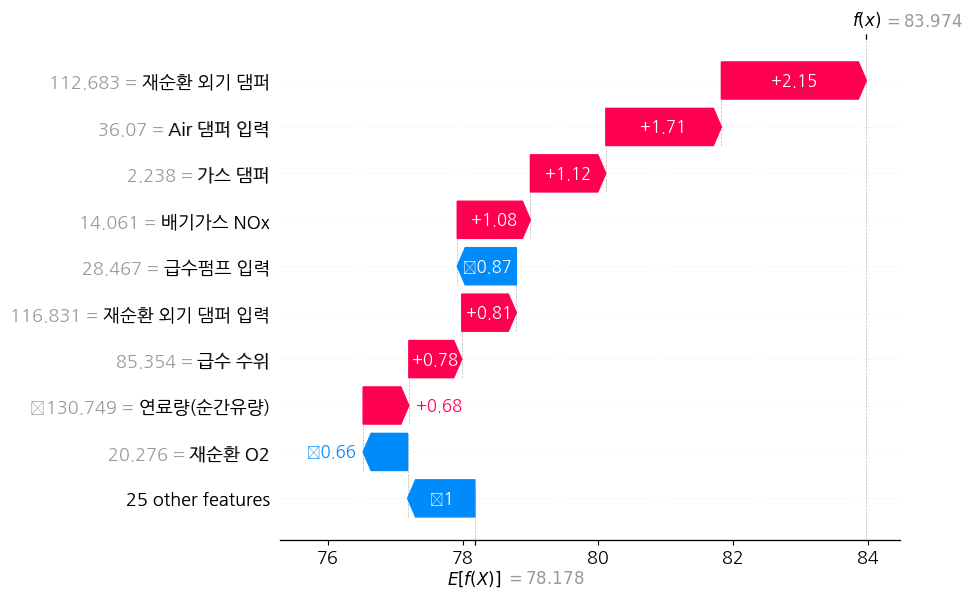

In [23]:
shap.plots.waterfall(shap_values[0])

In [24]:
shap.initjs()
shap.plots.force(shap_values[0])

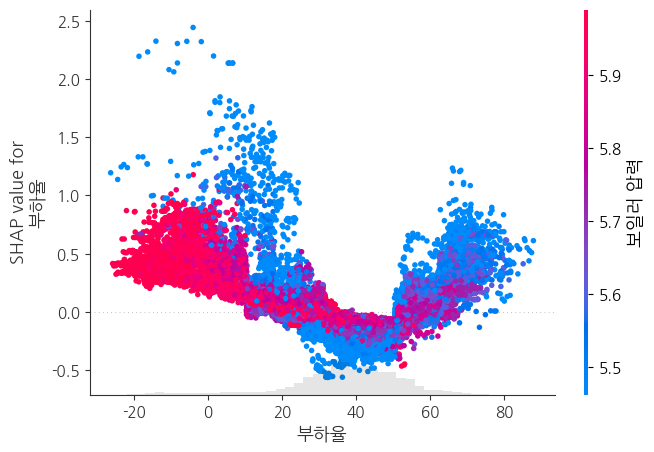

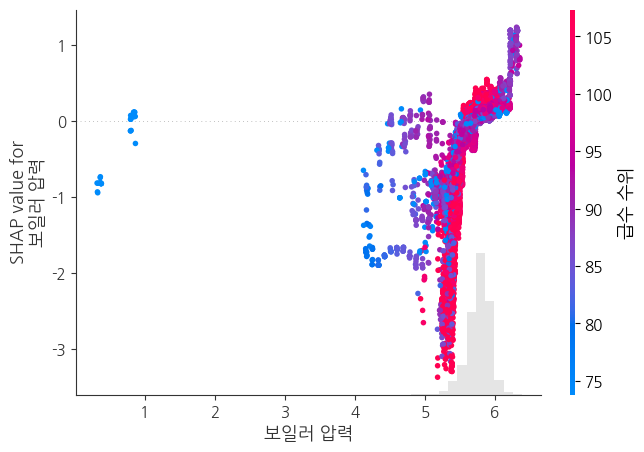

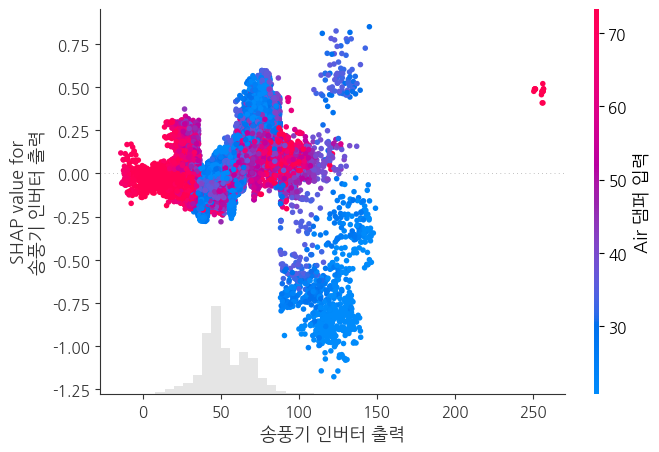

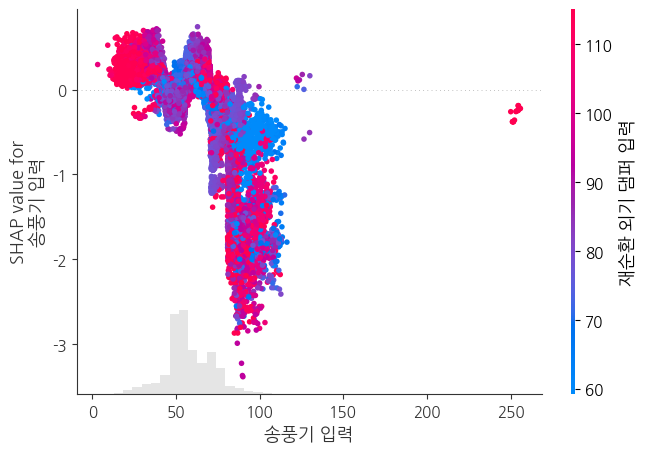

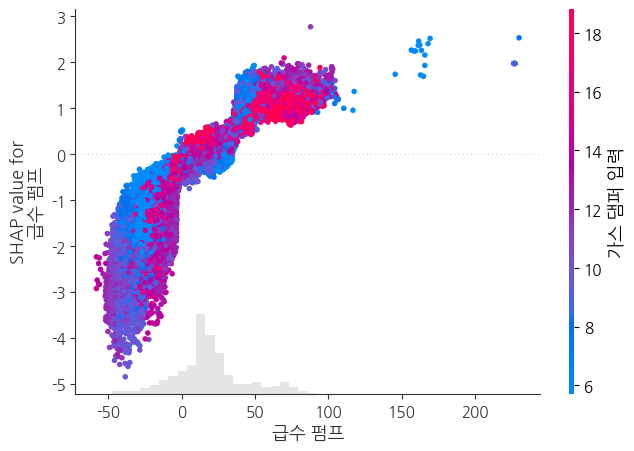

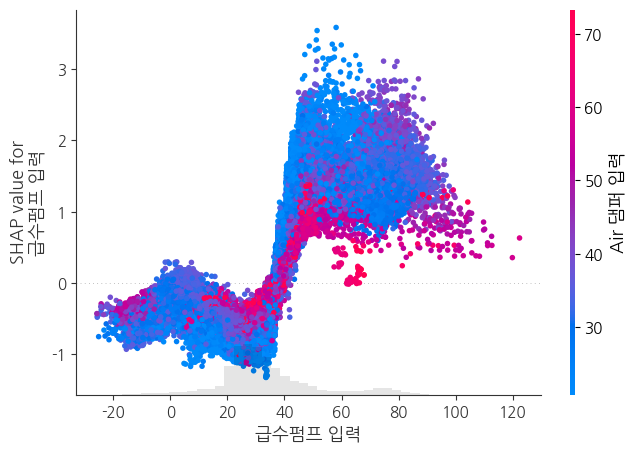

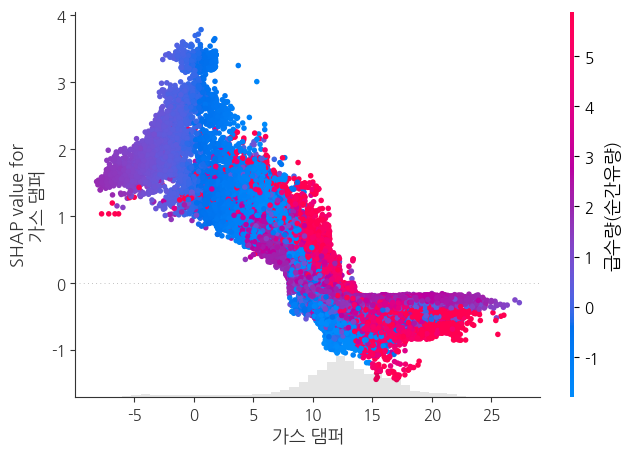

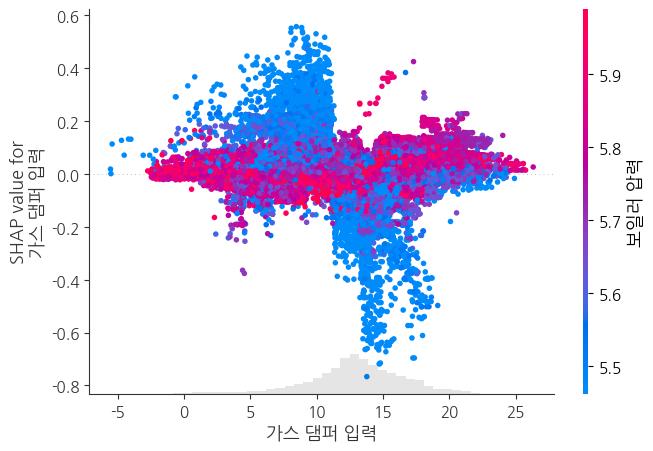

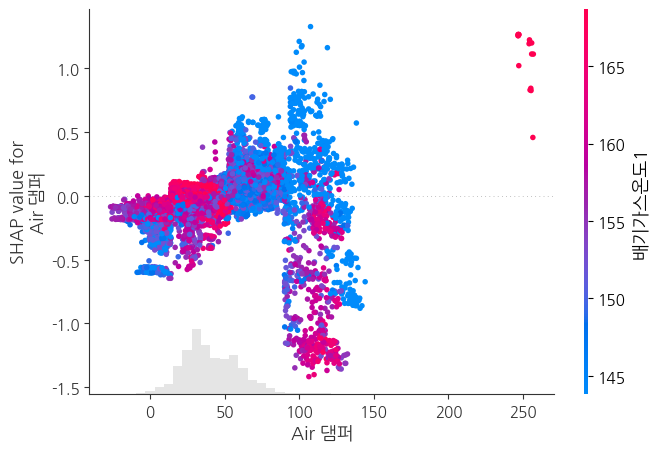

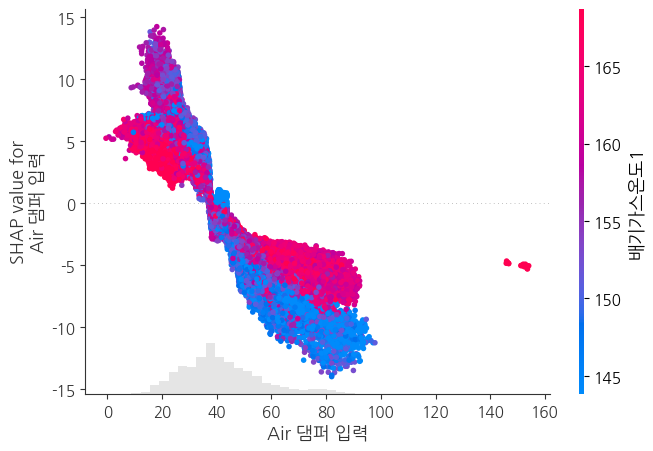

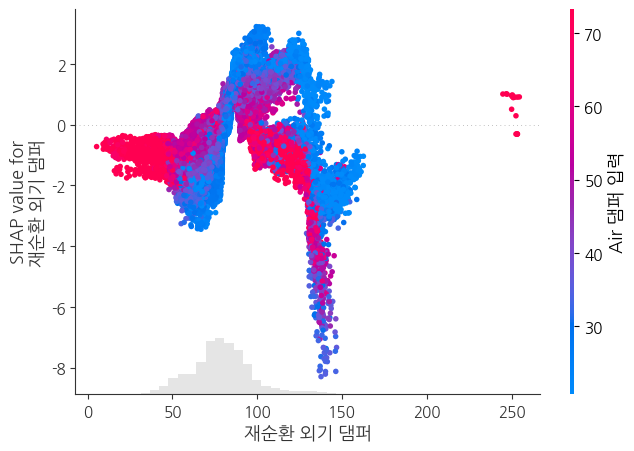

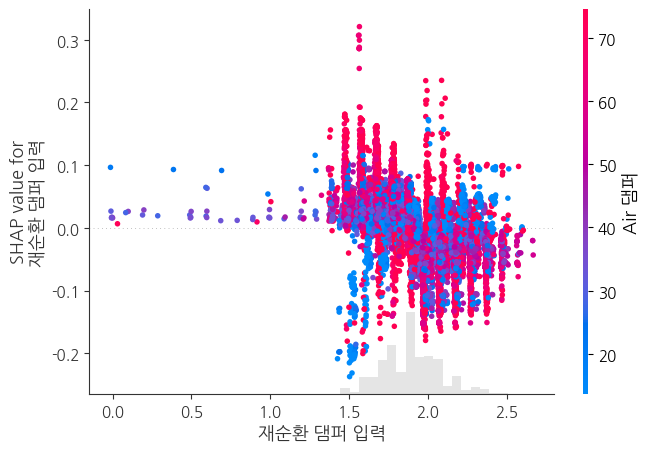

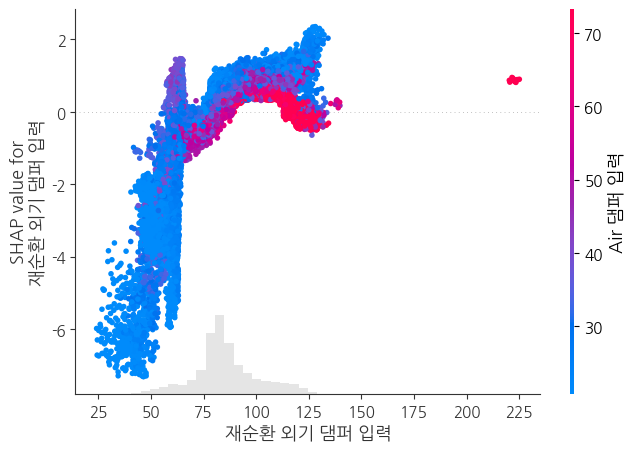

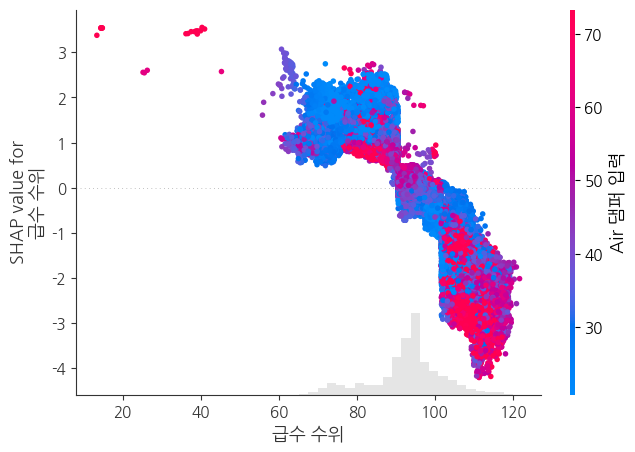

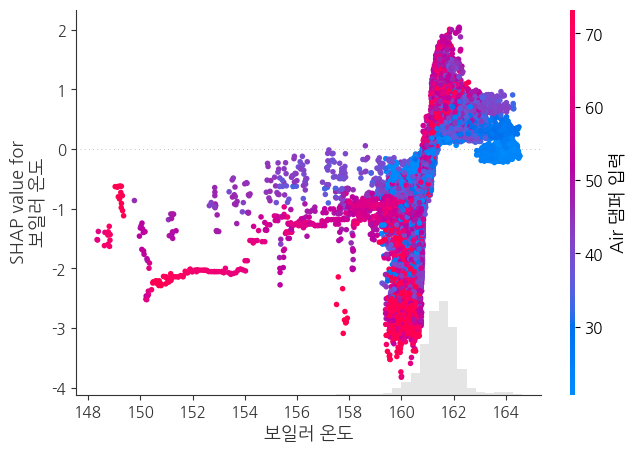

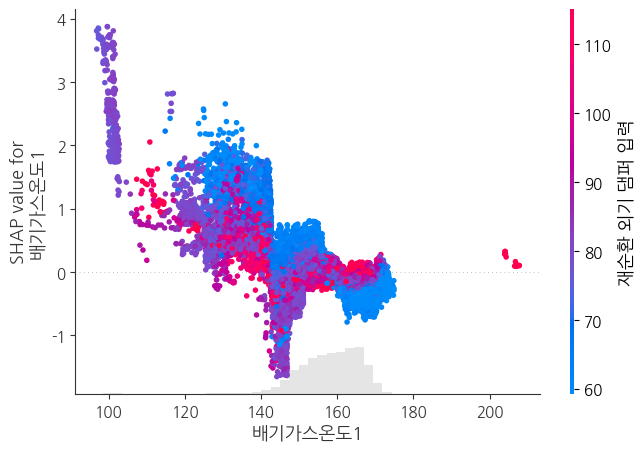

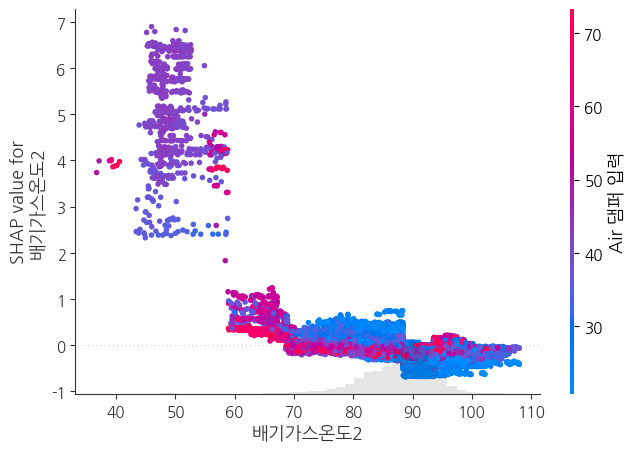

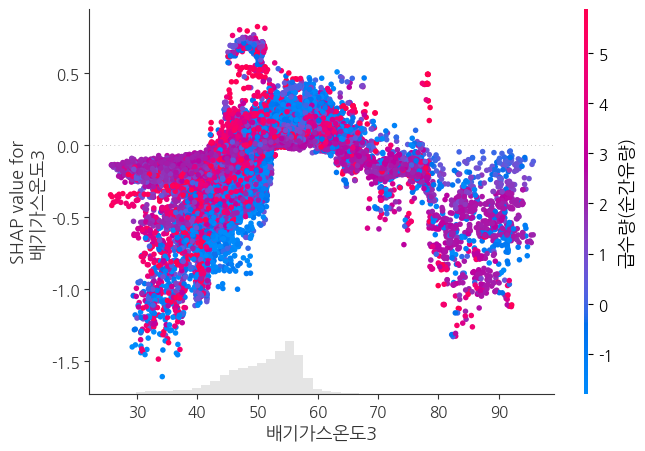

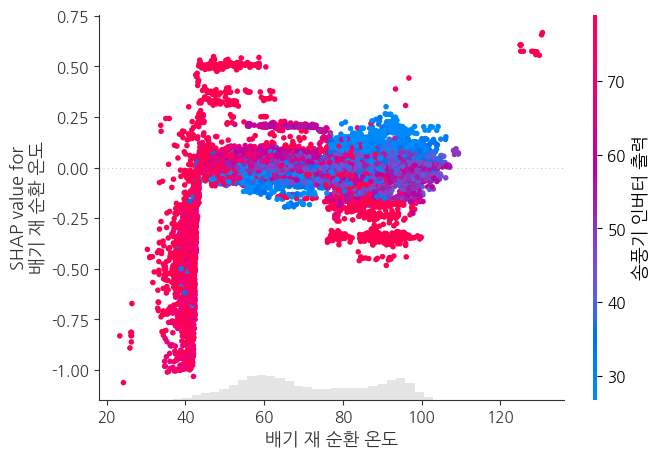

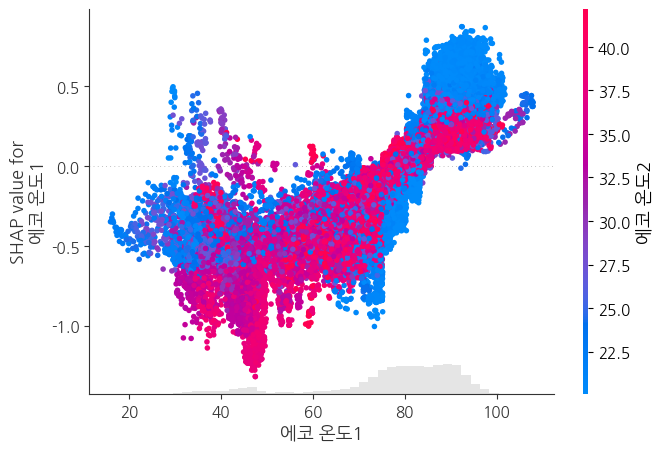

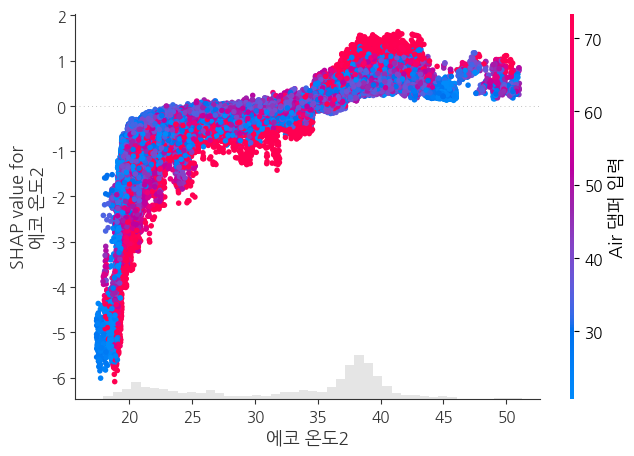

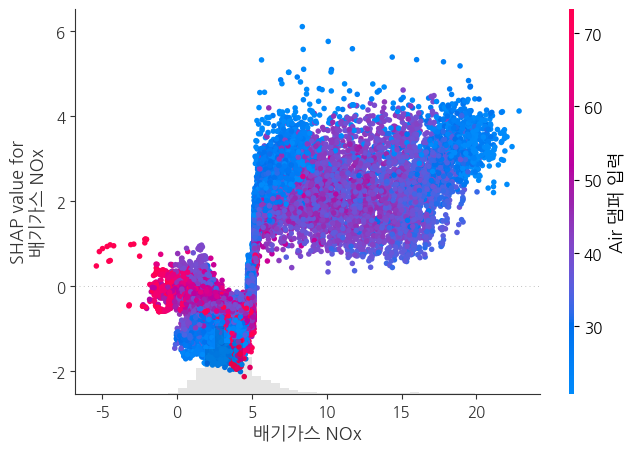

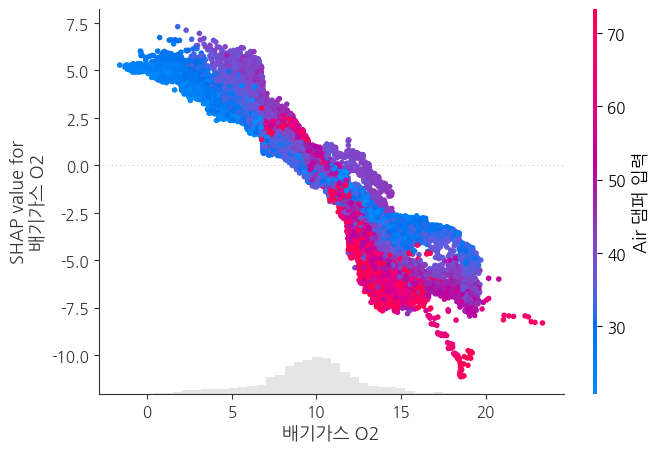

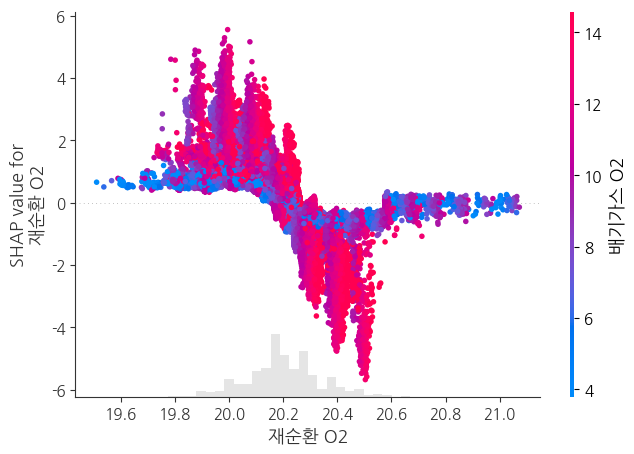

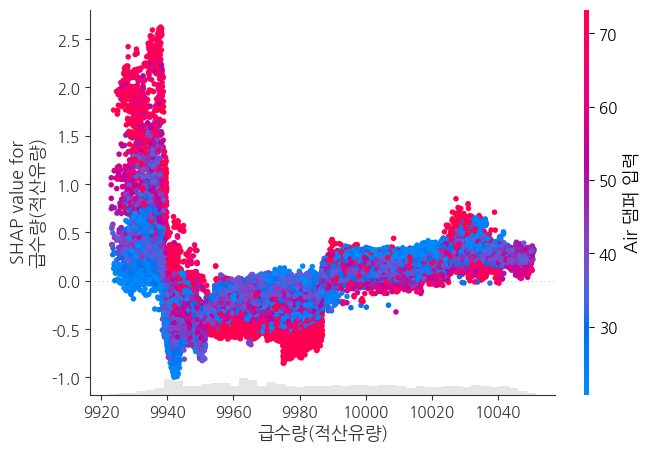

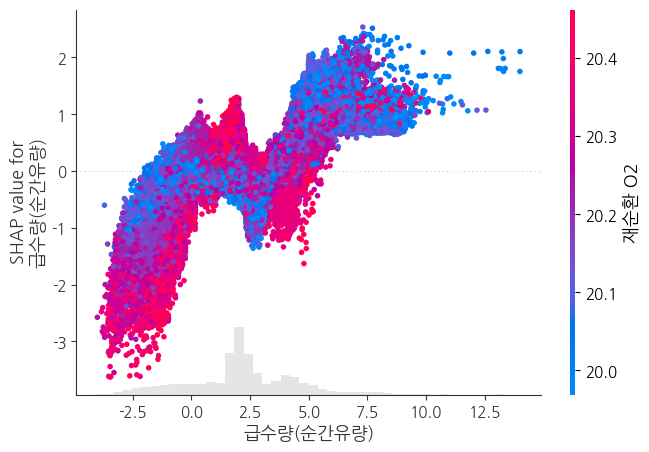

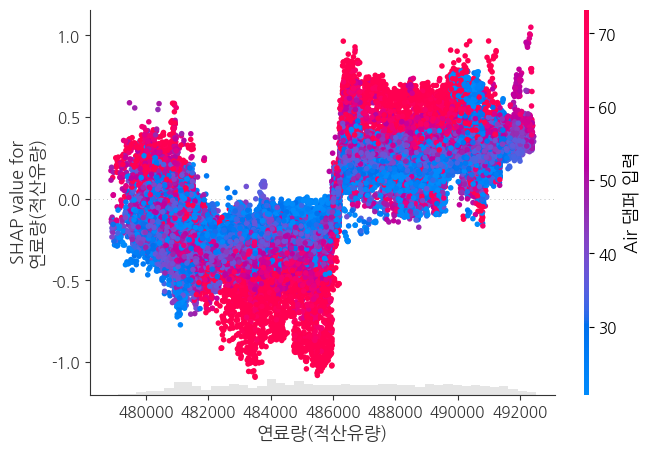

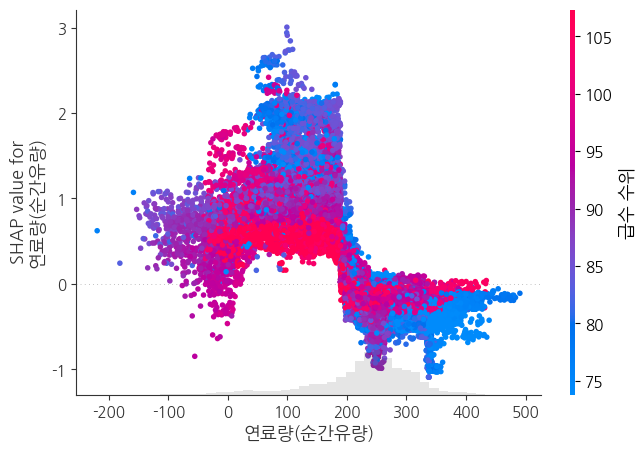

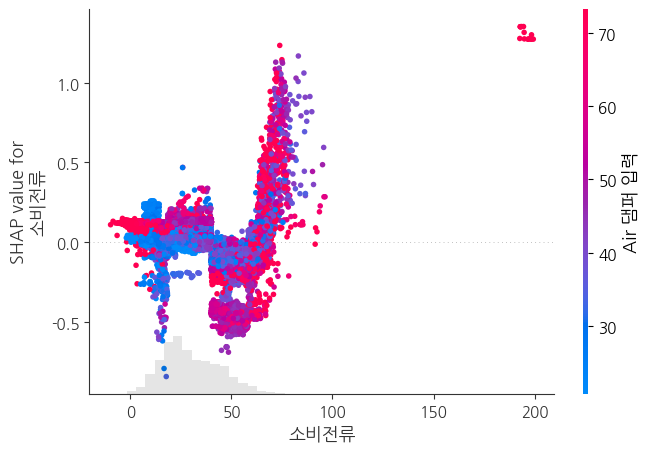

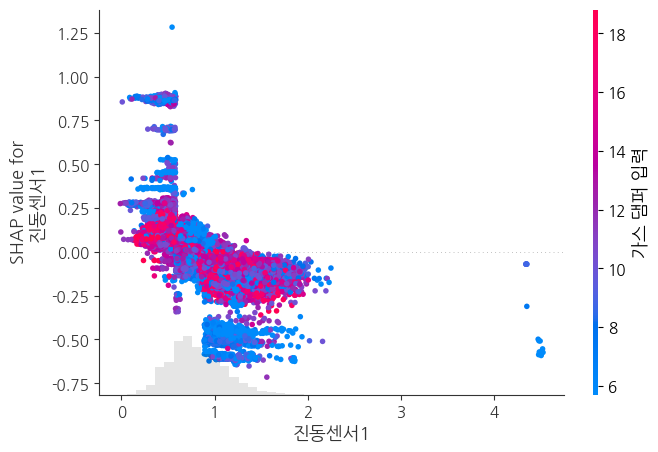

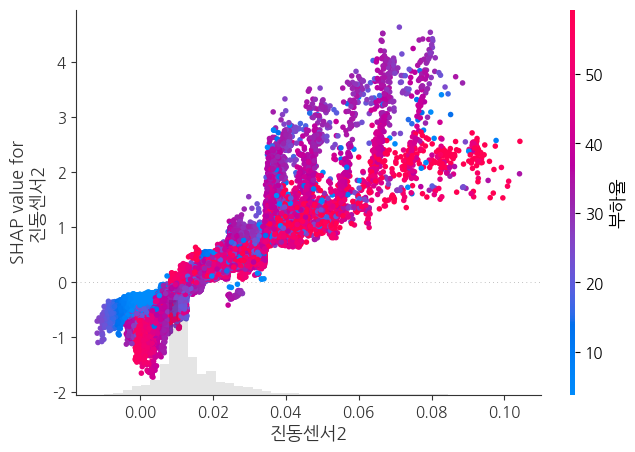

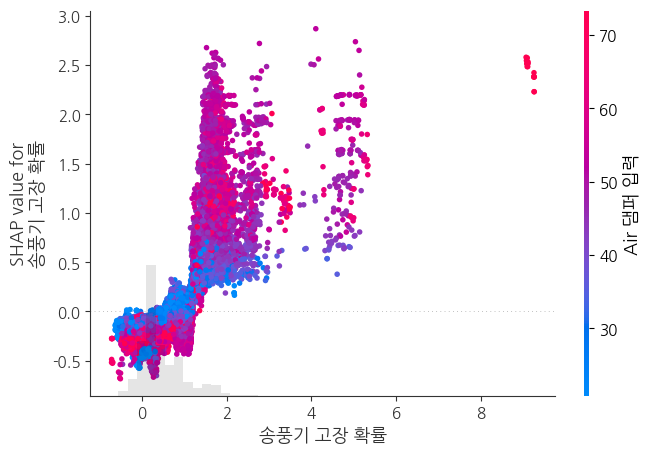

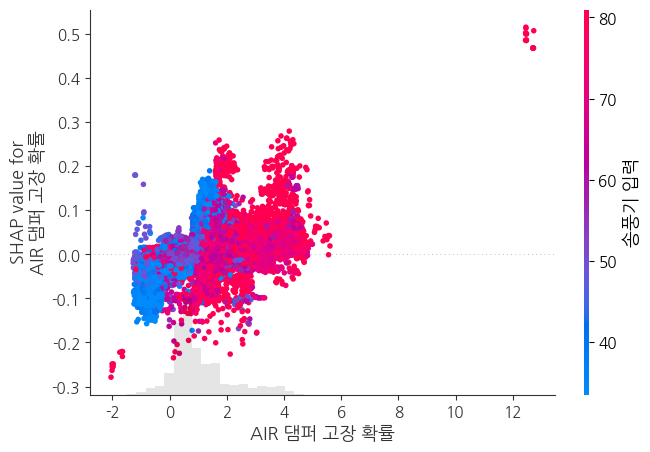

In [25]:
for i in range(0,33):
    shap.plots.scatter(shap_values[:, i], color=shap_values)

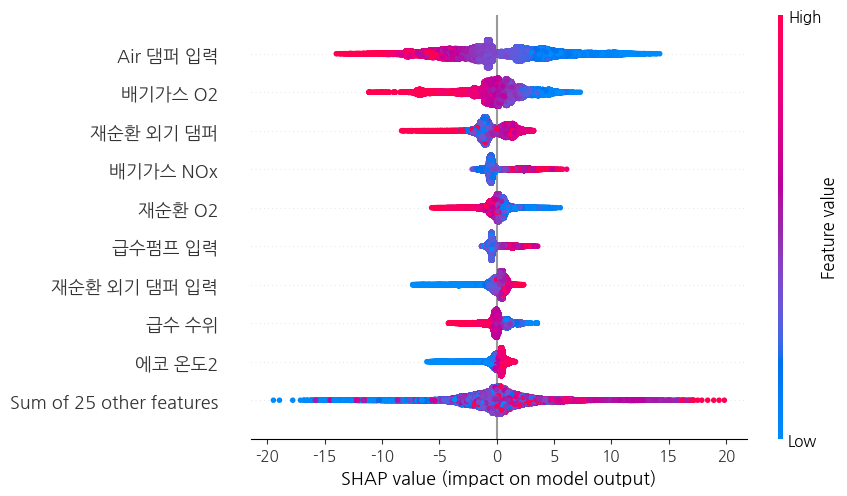

In [26]:
shap.plots.beeswarm(shap_values)

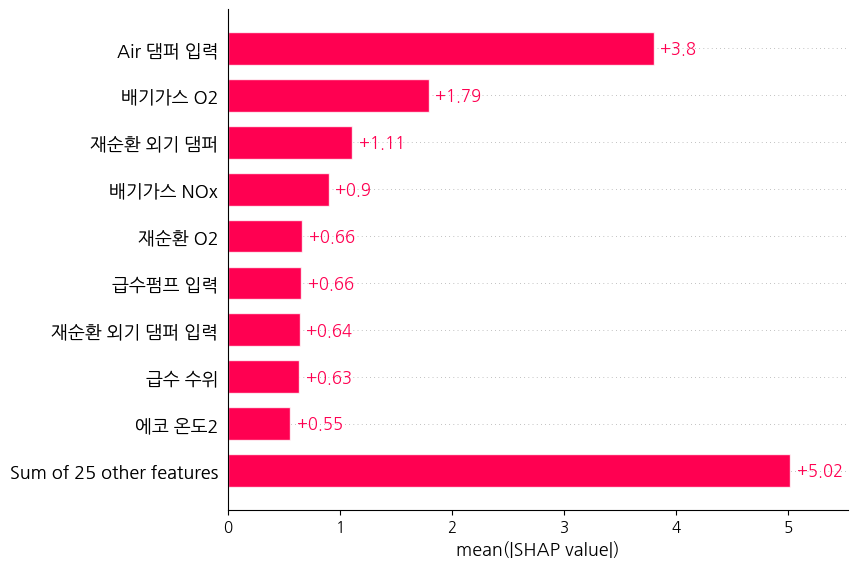

In [27]:
shap.plots.bar(shap_values)